In [1]:
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, roc_curve
import matplotlib.pyplot as plt
from joblib import load
from keras.models import load_model

Using TensorFlow backend.


# Compare Models
This will compare the final models and find the feature importances.

In [2]:
# Load data and stopwords
test_data = pd.read_pickle('../data/test_data.pkl')

with open('../data/stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

In [4]:
svm = {
    'count_model': load('../results/models/Count-SVM_model.joblib'),
    'count_test': load('../data/Count-SVM_test_vec.joblib'),
    'tfidf_model': load('../results/models/TF-IDF-SVM_model.joblib'),
    'tfidf_test': load('../data/TF-IDF-SVM_test_vec.joblib')
}

rf = {
    'count_model': load('../results/models/Count-RF_model.joblib'),
    'count_test': load('../data/Count-RF_test_vec.joblib'),
    'tfidf_model': load('../results/models/TF-IDF-RF_model.joblib'),
    'tfidf_test': load('../data/TF-IDF-RF_test_vec.joblib')
}

nn = {
    'count_model': load_model('../results/models/Count-NN_model.h5'),
    'count_test': load('../data/Count-NN_test_vec.joblib'),
    'tfidf_model': load_model('../results/models/TF-IDF-NN_model.h5'),
    'tfidf_test': load('../data/TF-IDF-NN_test_vec.joblib')
}

In [5]:
class CompareModels(object):
    def __init__(self, test_data, svm_dict, rf_dict, nn_dict):
        self.test_data = test_data
        self.svm_params = svm_dict
        self.rf_params = rf_dict
        self.nn_params = nn_dict
        self.scores = pd.DataFrame()
    
    def plot_roc_curves(self):
        fpr_svm_count, tpr_svm_count = self.get_fpr_tpr(self.svm_params['count_model'], self.svm_params['count_test'])
        fpr_svm_tfidf, tpr_svm_tfidf = self.get_fpr_tpr(self.svm_params['tfidf_model'], self.svm_params['tfidf_test'])
        
        fpr_rf_count, tpr_rf_count = self.get_fpr_tpr(self.rf_params['count_model'], self.rf_params['count_test'])
        fpr_rf_tfidf, tpr_rf_tfidf = self.get_fpr_tpr(self.rf_params['tfidf_model'], self.rf_params['tfidf_test'])
        
        fpr_nn_count, tpr_nn_count = self.get_fpr_tpr_keras(self.nn_params['count_model'], 
                                                            self.nn_params['count_test'])
        fpr_nn_tfidf, tpr_nn_tfidf = self.get_fpr_tpr_keras(self.nn_params['tfidf_model'], 
                                                            self.nn_params['tfidf_test'])
    
        plt.figure(figsize=(12, 10))
        plt.plot([0, 1], [0, 1], linestyle='--', color='#D3D3D3')
        plt.plot(fpr_svm_count, tpr_svm_count, color='#fadbd8', label='Count-SVM') # light red
        plt.plot(fpr_svm_tfidf, tpr_svm_tfidf, color='#943126', label='TF-IDF-SVM') # dark red
        plt.plot(fpr_rf_count, tpr_rf_count, color='#ebdef0', label='Count-RF') # light purple
        plt.plot(fpr_rf_tfidf, tpr_rf_tfidf, color='#512e5f', label='TF-IDF-RF') # dark purple
        plt.plot(fpr_nn_count, tpr_nn_count, color='#d6eaf8', label='Count-NN') # light blue
        plt.plot(fpr_nn_tfidf, tpr_nn_tfidf, color='#21618c', label='TF-IDF-NN') # dark blue
        plt.title('Receiver Operating Characteristic Curves', fontsize=20)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.savefig('../results/images/all_ROC_curve.png', bbox_inches='tight')
        return None
    
    def get_fpr_tpr(self, clf, X_vec):
        y_test = self.test_data['label'].values
        y_prob = clf.predict_proba(X_vec)
        y_prob = y_prob[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        return fpr, tpr
    
    def get_fpr_tpr_keras(self, model, X_vec):
        y_test = self.test_data['label'].values
        y_prob = model.predict(X_vec).flatten()

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        return fpr, tpr
        

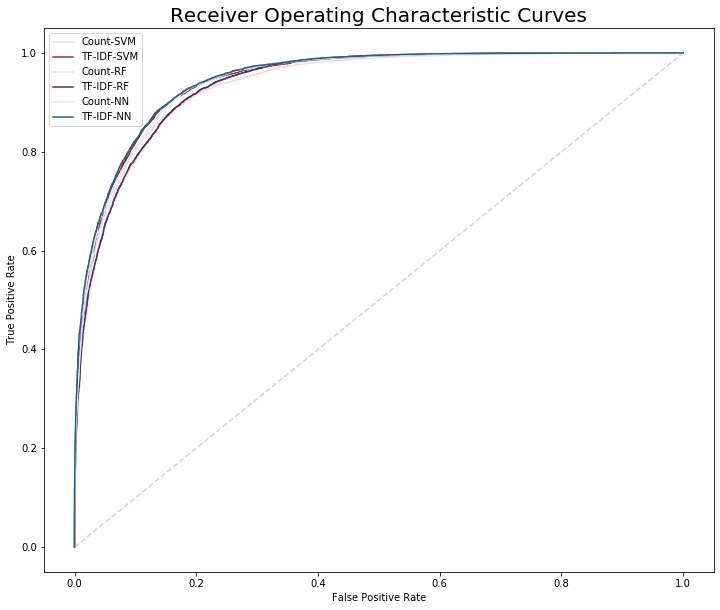

In [6]:
compare_models = CompareModels(test_data, svm, rf, nn)
compare_models.plot_roc_curves()

## Feature Importances
This will find the importance of each feature within the models.

In [7]:
train_data = pd.read_pickle('../data/train_data.pkl')
X_train = train_data['text'].values
test_data = pd.read_pickle('../data/test_data.pkl')
X_test = train_data['text'].values

### Random Forest

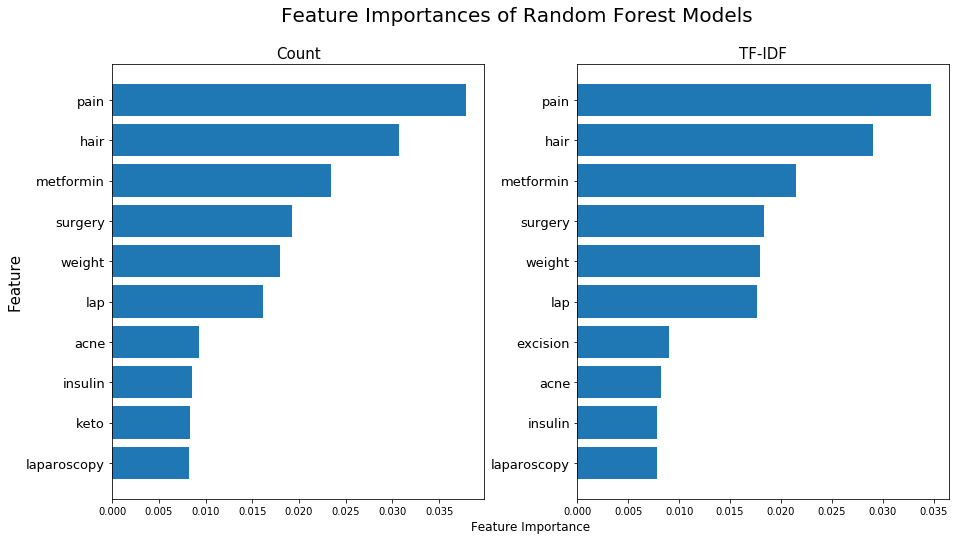

In [8]:
ngram_range = (1,1)
max_df = 1.0
min_df = 0

vectorizer = CountVectorizer(ngram_range=ngram_range, 
                             max_df=max_df, 
                             min_df=min_df, 
                             stop_words=stopwords)

vectorizer.fit(X_train)

names = vectorizer.get_feature_names()
feature_importances = rf['count_model'].feature_importances_

fi_df = pd.DataFrame({'token':names, 'importance': feature_importances})
count_top = fi_df.sort_values('importance', ascending=False).head(10).sort_values('importance', ascending=True)


ngram_range = (1,1)
max_df = 0.5
min_df = 0

vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                             max_df=max_df, 
                             min_df=min_df, 
                             stop_words=stopwords)

vectorizer.fit(X_train)

names = vectorizer.get_feature_names()
feature_importances = rf['tfidf_model'].feature_importances_

fi_df = pd.DataFrame({'token':names, 'importance': feature_importances})
tfidf_top = fi_df.sort_values('importance', ascending=False).head(10).sort_values('importance', ascending=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Feature Importances of Random Forest Models', size=20)
fig.add_subplot(frame_on=False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
plt.xlabel('Feature Importance', size=12)
ax1.barh(y=count_top['token'].values, width=count_top['importance'].values)
ax1.set_ylabel('Feature', size=15)
ax1.tick_params(axis='y', which='major', labelsize=13)
ax1.tick_params(axis='x', which='major', labelsize=10)
ax2.barh(y=tfidf_top['token'].values, width=tfidf_top['importance'].values)
ax2.tick_params(axis='y', which='major', labelsize=13)
ax2.tick_params(axis='x', which='major', labelsize=10)
ax1.set_title('Count', size=15)
ax2.set_title('TF-IDF', size=15)
fig.subplots_adjust(wspace=0.25)
plt.savefig('../results/images/rf_feature_importance.png', bbox_inches='tight')
plt.show()

### Support Vector Machine

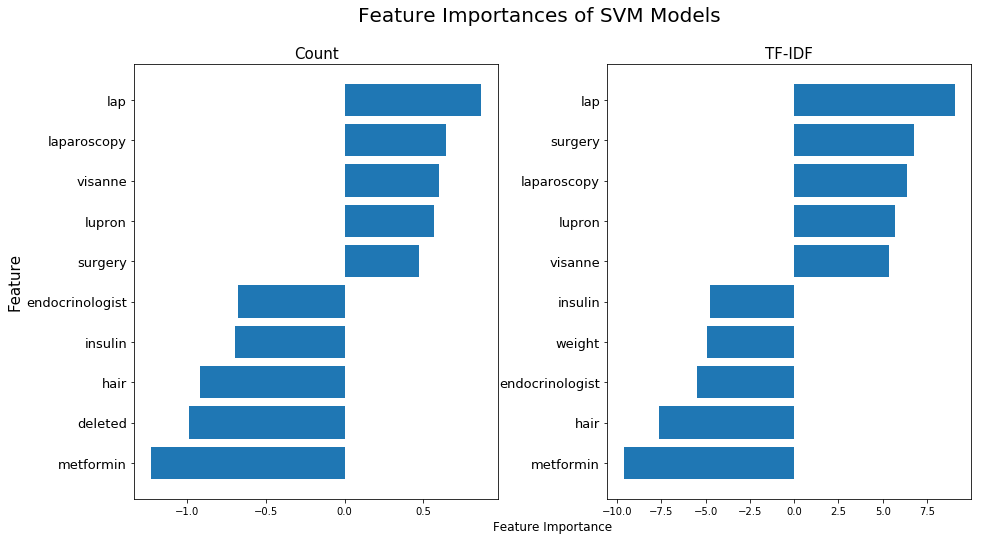

In [9]:
ngram_range = (1,2)
max_df = 0.5
min_df = 0

vectorizer = CountVectorizer(ngram_range=ngram_range, 
                             max_df=max_df, 
                             min_df=min_df, 
                             stop_words=stopwords)

vectorizer.fit(X_train)

names = vectorizer.get_feature_names()
coef = svm['count_model'].coef_.toarray().flatten()
fi_df = pd.DataFrame({'token':names, 'importance': coef})

pos = fi_df.sort_values('importance', ascending=False).head(5).sort_values('importance', ascending=True)
neg = fi_df.sort_values('importance', ascending=True).head(5)

count_top = pd.concat([neg, pos])


ngram_range = (1,2)
max_df = 0.25
min_df = 0

vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                             max_df=max_df, 
                             min_df=min_df, 
                             stop_words=stopwords)

vectorizer.fit(X_train)

names = vectorizer.get_feature_names()
coef = svm['tfidf_model'].coef_.toarray().flatten()
fi_df = pd.DataFrame({'token':names, 'importance': coef})

pos = fi_df.sort_values('importance', ascending=False).head(5).sort_values('importance', ascending=True)
neg = fi_df.sort_values('importance', ascending=True).head(5)

tfidf_top = pd.concat([neg, pos])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Feature Importances of SVM Models', size=20)
fig.add_subplot(frame_on=False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
plt.xlabel('Feature Importance', size=12)
ax1.barh(y=count_top['token'].values, width=count_top['importance'].values)
ax1.set_ylabel('Feature', size=15)
ax1.tick_params(axis='y', which='major', labelsize=13)
ax1.tick_params(axis='x', which='major', labelsize=10)
ax2.barh(y=tfidf_top['token'].values, width=tfidf_top['importance'].values)
ax2.tick_params(axis='y', which='major', labelsize=13)
ax2.tick_params(axis='x', which='major', labelsize=10)
ax1.set_title('Count', size=15)
ax2.set_title('TF-IDF', size=15)
fig.subplots_adjust(wspace=0.3)
plt.savefig('../results/images/svm_feature_importance.png', bbox_inches='tight')
plt.show()

### Neural Net
This gets more complicated here as you have additional layers with different weights. Advanced methods must be used to understand what is happening in this model.